# Scottish Borders Council Future Analysis

In [29]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [30]:
from data_reader_writer import data_writer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pypsa

In [31]:
year = 2050

In [32]:
start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:30:00'
# time step as fraction of hour
time_step = 1.0
if year > 2020:
    data_writer(start, end, time_step, year, year_baseline=2020, scenario='Leading The Way', merge_generators=True)
if year <= 2020:
    data_writer(start, end, time_step, year, merge_generators=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:201: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [33]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon Penwortham', 'Tidal lagoon S.W.Penisula',
       'Tidal stream Deeside', 'Tidal stream Harker', 'Tidal stream Lovedean',
       'Tidal stream Melksham', 'Tidal stream Penwortham',
       'Tidal stream S.W.Penisula', 'Wave power Beauly', 'Wave power Melksham',
       'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Run the optimisation...

In [34]:
if year == 2030:
    contingency_factor = 2
elif year == 2040:
    contingency_factor = 3
elif year == 2050:
    contingency_factor = 4
else:
    contingency_factor = 1

network.lines.s_max_pu *= contingency_factor

solver_options = {'name': 'gurobi',
                  'threads': 4,
                  'method': 2, # barrier
                  'crossover': 0,
                  'BarConvTol': 1.e-5,
                  'FeasibilityTol': 1.e-6,
                  'AggFill': 0,
                  'PreDual': 0,
                  'GURO_PAR_BARDENSETHRESH': 200}
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False, solver_options=solver_options)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 133.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-yj1ov5um.lp
Reading time = 84.10 seconds
obj: 37850286 rows, 10713481 columns, 66449921 nonzeros
No parameters matching 'name' found
Set parameter Threads to value 4
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarConvTol to value 1e-05
Set parameter AggFill to value 0
Set parameter PreDual to value 0
Set parameter GURO_PAR_BARDENSETHRESH to value 200
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads
Optimize a model with 37850286 rows, 10713481 columns and 66449921 nonzeros
Model fingerprint: 0x9daafd6b
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-06, 1e+09]
Presolve removed 36001942 rows and 1105214 columns (presolve time = 5s) ...
Presolve removed 36005310 rows and 1175090 columns (preso

INFO:pypsa.linopf:Optimization successful. Objective value: 5.22e+16


('ok', 'optimal')

In [35]:
network.export_to_csv_folder(str(year))

INFO:pypsa.io:Exported network 2050 has loads, buses, links, lines, storage_units, generators


snapshot
2050-01-01 00:00:00    164.098865
2050-01-01 01:00:00    163.128766
2050-01-01 02:00:00    160.184027
2050-01-01 03:00:00    152.713116
2050-01-01 04:00:00    148.775318
                          ...    
2050-12-31 19:00:00    246.686445
2050-12-31 20:00:00    230.430109
2050-12-31 21:00:00    214.343111
2050-12-31 22:00:00    197.756712
2050-12-31 23:00:00    187.326712
Name: Eccles, Length: 8760, dtype: float64


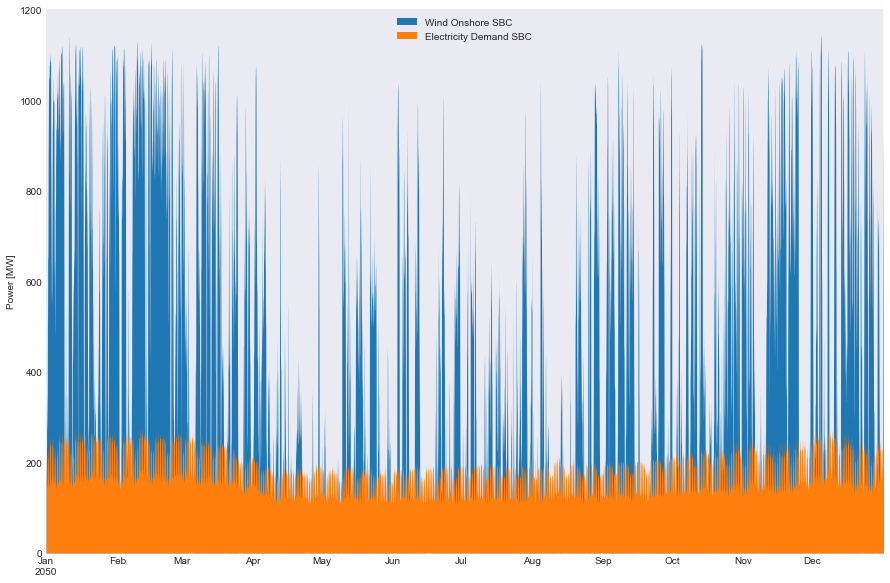

In [36]:
plt.style.use('seaborn-dark')

p_eccles = network.generators_t.p['Wind Onshore Eccles']
demand_eccles = network.loads_t.p['Eccles']
print(demand_eccles)
demand_eccles.name = 'Demand Eccles'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_eccles.rename('Wind Onshore SBC').plot(kind="area", ax=ax, linewidth=0)
demand_eccles.rename('Electricity Demand SBC').plot(kind="area", ax=ax, linewidth=0)
ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()
plt.show()

The total modelled generation from wind in Eccles was 4,689 GWh, while the total demand was 500 GWh.

Generation is almost 10x larger than demand.

As a sense check there are 1,356 MW of wind farms on Scottish Borders list which assuming a capacity factor of 30%, gives 1358 * 8760 * 0.3 = 3,564 GWh.

In [37]:
p_eccles.sum()

3687886.3504333543

In [38]:
demand_eccles.sum()

1565579.2181681877

In [39]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

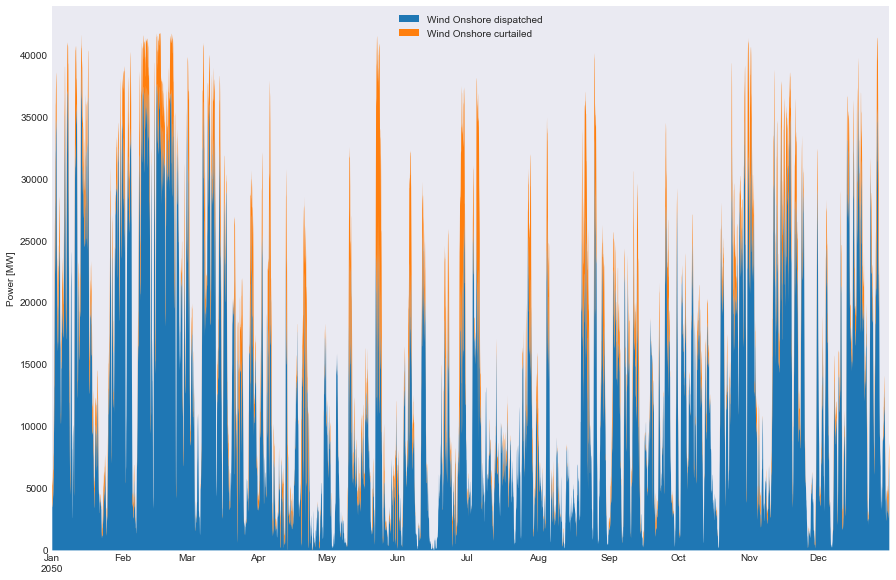

In [40]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
file = str(year) + '_wind_data.csv'
p_df.to_csv(file)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()

Percentage of wind curtailed

In [41]:
round(100 * (p_curtailed_by_carrier['Wind Onshore'].sum()) / p_available_by_carrier['Wind Onshore'].sum(), 1)

16.0

<AxesSubplot:xlabel='snapshot'>

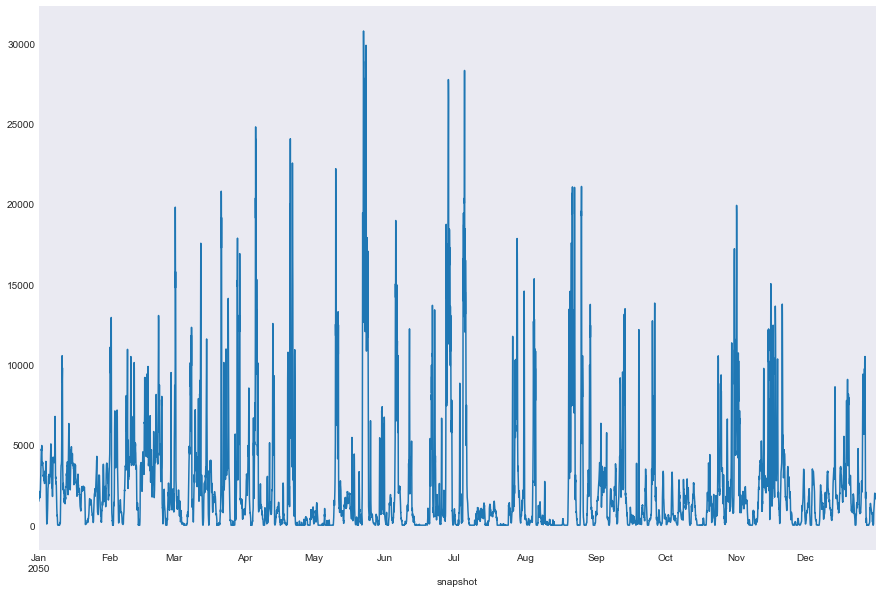

In [42]:
p_curtailed_by_carrier['Wind Onshore'].plot(figsize=(15,10))